# Определение стоимости автомобилей

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение файла с данными и сохранение в df с использованием конструкции try-except
try:
    df = pd.read_csv('C:/Users/datasets/autos.csv') # локальный путь
except:
    df = pd.read_csv('//datasets/autos.csv') # серверный путь

In [3]:
# просмотр первых пяти строк 
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# получение общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# подсчет пропусков
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
# оценка пропусков в процентном соотношении
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Итак, мы имеем датасет, состоящий из 16 столбцов, из них пропуски присутствуют в 5 столбцах. Оставим только те столбцы, которые влияют на цену автомобиля, а так же проведем предобработку данных.

In [7]:
df_auto = df[['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
              'NotRepaired', 'Price']]

df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   NotRepaired       283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [8]:
# просмотр уникальных значений столбца Model
df_auto['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Заменим пропуски в данном столбце значением `unknown`, так как пропущенные данные мы никак не может восстановить.

In [9]:
# заполнение пропусков в столбце Model
df_auto['Model'] = df_auto['Model'].fillna('unknown')

In [10]:
# просмотр уникальных значений столбца VehicleType
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заполним пропуски в данном столбце самым популярным типом кузова по каждой модели. Для этого сгруппируем данные и создадим словарь, где ключ - это модель автомобиля, а значение - тип кузова.

In [11]:
# создание словаря с популярными типами кузова по каждой модели
vehicle_dict = df_auto.groupby('Model')['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()
vehicle_dict

{'100': 'sedan',
 '145': 'small',
 '147': 'sedan',
 '156': 'wagon',
 '159': 'wagon',
 '1_reihe': 'small',
 '1er': 'sedan',
 '200': 'sedan',
 '2_reihe': 'small',
 '300c': 'wagon',
 '3_reihe': 'sedan',
 '3er': 'sedan',
 '4_reihe': 'wagon',
 '500': 'small',
 '5_reihe': 'bus',
 '5er': 'sedan',
 '601': 'sedan',
 '6_reihe': 'wagon',
 '6er': 'coupe',
 '7er': 'sedan',
 '80': 'sedan',
 '850': 'wagon',
 '90': 'sedan',
 '900': 'convertible',
 '9000': 'sedan',
 '911': 'coupe',
 'a1': 'small',
 'a2': 'small',
 'a3': 'sedan',
 'a4': 'wagon',
 'a5': 'coupe',
 'a6': 'wagon',
 'a8': 'sedan',
 'a_klasse': 'sedan',
 'accord': 'sedan',
 'agila': 'small',
 'alhambra': 'bus',
 'almera': 'sedan',
 'altea': 'bus',
 'amarok': 'suv',
 'antara': 'suv',
 'arosa': 'small',
 'astra': 'sedan',
 'auris': 'sedan',
 'avensis': 'wagon',
 'aveo': 'small',
 'aygo': 'small',
 'b_klasse': 'bus',
 'b_max': 'bus',
 'beetle': 'sedan',
 'berlingo': 'bus',
 'bora': 'sedan',
 'boxster': 'convertible',
 'bravo': 'sedan',
 'c1': 's

In [12]:
# создание функции для заполнения пропусков в столбце VehicleType
def vehicle_type_find(row):    
    if pd.isnull(row['VehicleType']):
        return vehicle_dict[row['Model']]
    else:
        return row['VehicleType']

df_auto['VehicleType'] = df_auto.apply(vehicle_type_find, axis=1) # замена пропусков методом apply, 
                                                                # который в качестве аргумента принимает нашу функцию

In [13]:
# проверка
print(df_auto['VehicleType'].head())
df_auto['VehicleType'].isna().sum()

0    sedan
1    coupe
2      suv
3    small
4    small
Name: VehicleType, dtype: object


0

In [14]:
# просмотр уникальных значений столбца FuelType
df_auto['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Аналогичным способом заполним пропуски в столбце FuelType.

In [15]:
# замена пропусков в FuelType
fuel_dict = df_auto.groupby('Model')['FuelType'].agg(lambda x:x.value_counts().index[0]).to_dict()

def fuel_type_find(row):    
    if pd.isnull(row['FuelType']):
        return vehicle_dict[row['Model']]
    else:
        return row['FuelType']

df_auto['FuelType'] = df_auto.apply(fuel_type_find, axis=1)

In [16]:
# просмотр уникальных значений столбца NotRepaired
print(df_auto['NotRepaired'].unique())
df_auto['NotRepaired'].value_counts(normalize=True)

[nan 'yes' 'no']


no     0.872697
yes    0.127303
Name: NotRepaired, dtype: float64

В столбце `NotRepaired` заменим пропуски на `no`, имеяя ввиду, что ремонта не было

In [17]:
# замена пропусков в NotRepaired
df_auto['NotRepaired'] = df_auto['NotRepaired'].fillna('no')

In [18]:
# просмотр уникальных значений столбца Gearbox
print(df_auto['Gearbox'].unique())
df_auto['Gearbox'].value_counts(normalize=True)

['manual' 'auto' nan]


manual    0.80186
auto      0.19814
Name: Gearbox, dtype: float64

Пропуски заполним `manual`.

In [19]:
# замена пропусков в Gearbox
df_auto['Gearbox'] = df_auto['Gearbox'].fillna('manual')

In [20]:
# проверка на пропуски
df_auto.isna().sum()

VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
Price               0
dtype: int64

Теперь проверим нет ли в оставшихся столбцах аномальных значений или выбросов, а также проверим наличие дубликатов.

In [21]:
# просмотр уникальных значений столбца RegistrationYear
df_auto['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Мы видим некорректные значения. Машина явно не может быть зарегистрирована позже текущего года. Удалим данные значения, нижнюю границу определим в районе 1960 года, такие автомобили теоретически могут находиться еще в эксплуатации.

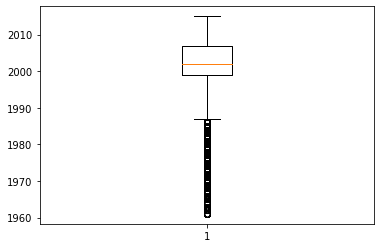

In [22]:
# методом query убираем некорректные значения
df_filtered = df_auto.query('1960<RegistrationYear<2016')
plt.boxplot(df_filtered['RegistrationYear']); # "ящик с усами"

In [63]:
# просмотр возможных диапозонов для разбиения на группы
pd.qcut(df_filtered['RegistrationYear'], q=4)

1           (2007.0, 2015.0]
2           (2003.0, 2007.0]
3           (1999.0, 2003.0]
4           (2007.0, 2015.0]
5         (1960.999, 1999.0]
                 ...        
354360      (2003.0, 2007.0]
354362      (2003.0, 2007.0]
354366      (1999.0, 2003.0]
354367    (1960.999, 1999.0]
354368      (1999.0, 2003.0]
Name: RegistrationYear, Length: 244434, dtype: category
Categories (4, interval[float64]): [(1960.999, 1999.0] < (1999.0, 2003.0] < (2003.0, 2007.0] < (2007.0, 2015.0]]

In [24]:
# создание функции для разделения данных на группы одинакового размера по возрасту машины
def car_age(year):
    if year<=1999.0:
        return 'super retro'
    if year<=2002.0:
        return 'retro'
    if year<=2007.0:
        return 'old'
    return 'new'

df_filtered['Car_age'] = df_filtered['RegistrationYear'].apply(car_age) # создание нового столбца

In [25]:
# проверка работы функции
car_age(2009)

'new'

Тепепь посмотрим выбросы в столбце `Power`.

In [26]:
# просмотр уникальных значений столбца Power
df_filtered['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,   136,   160,   231,   118,
         193,    99,    60,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,   143,   286,   232,   150,   156,
          80,    82,    90,   155,    54,   185,    87,   180,    86,
          84,   224,   235,   200,   178,   265,    77,   110,   144,
         120,   116,   184,   126,   204,    88,   194,    64,   305,
         197,   179,   250,    45,   313,    41,   165,    98,   130,
         114,   211,    56,   201,   213,    58,   107,   174,   100,
         220,    73,   192,    68,    66,   299,    74,    52,   147,
          71,    97,    65,   239,   203,     5,   300,   103,    85,
         258,   320,    63,    81,   148,    44,    83,   145,    55,
         230,   280,   260,   104,   188,   333,   186,   117,   141,
         132,   234,   158,    39,    92,    51,   135,    53,   209,
          43,   146,

In [27]:
# просмотр информации о данных столбце Power
df_filtered['Power'].describe()

count    329630.000000
mean        112.025714
std         182.488631
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Удалим строки с нулевыми значениями и с значением мощности более 1000 л.с.

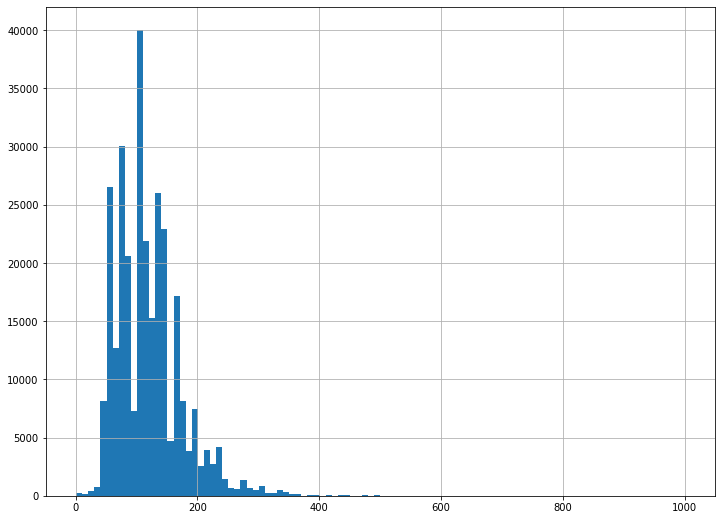

In [28]:
# методом query убираем нулевые значения и выбросы
df_filtered = df_filtered.query('0<Power<=1000')
df_filtered['Power'].hist(bins=100, figsize=(12,9)); # построение гистограммы

Теперь посмотрим значения у целевого признака.

In [29]:
# просмотр значений столбца Price
df_filtered['Price'].value_counts()

0        5991
1500     4331
500      4264
2500     3635
1200     3631
         ... 
10898       1
3991        1
11923       1
13456       1
8188        1
Name: Price, Length: 3575, dtype: int64

Есть много объявлений, где указана цена 0 евро. Исключим их из наших данных.

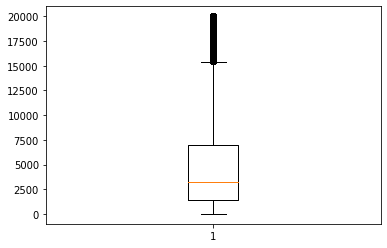

In [30]:
# методом query убираем нулевые значения
df_filtered = df_filtered.query('Price>0')
plt.boxplot(df_filtered['Price']);

И последнее, проверим имеются ли в данных дубликаты.

In [31]:
# подсчет количества дубликатов
df_filtered.duplicated().value_counts()

False    244434
True      45612
dtype: int64

In [32]:
# удаление дубликатов
df_filtered = df_filtered.drop_duplicates()
df_filtered.duplicated().sum()

0

## Обучение моделей

Для начала создадим переменные с признакими и целевым признаком, а так же применим one hot encoding и разобьем данные на тренировочную и тестовую выборки.

In [33]:
# создание переменных features и target
features = df_filtered.drop('Price', axis=1)
target = df_filtered['Price']

categorical_feats = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'Car_age'] # категориальные признаки

In [34]:
# разделение данных на тестовую и тренировочную выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((183325, 10), (61109, 10), (183325,), (61109,))

In [35]:
#OHE кодирование
ohe = pd.get_dummies(features, drop_first=True)
ohe_features_test = pd.get_dummies(features_test)

ohe_features = ohe.loc[features_train.index, :]
ohe_features_test = ohe.loc[features_test.index, :]

Для обучения будет использовать следующие модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor и LGBMRegressor.

In [36]:
%%time

# LinearRegression
model = LinearRegression()
MSE_LR = cross_val_score(model, ohe_features, target_train, cv=5, scoring='neg_mean_squared_error')
print('RMSE:',(MSE_LR.mean()* -1)**0.5)

RMSE: 2349.621346279952
CPU times: user 1min, sys: 35.8 s, total: 1min 36s
Wall time: 1min 36s


In [37]:
%%time

# DecisionTreeRegressor
param_grid = {'max_depth': range(2, 15)}
model = DecisionTreeRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
search.fit(ohe_features, target_train)
print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

RMSE: 1907.6031251844643 при значениях гиперпараметров: {'max_depth': 14}
CPU times: user 2min 34s, sys: 9.36 s, total: 2min 44s
Wall time: 2min 45s


In [38]:
%%time

# RandomForestRegressor
param_grid = {'n_estimators': range(1, 31, 10)}
model = RandomForestRegressor(random_state=12345, max_depth=10)
search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
search.fit(ohe_features, target_train)
print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

RMSE: 1913.9292862249 при значениях гиперпараметров: {'n_estimators': 21}
CPU times: user 5min 48s, sys: 1.96 s, total: 5min 50s
Wall time: 5min 53s


In [39]:
%%time

# CatBoostRegressor
param_grid = {'learning_rate':[0.1, 0.5, 0.8]}
model = CatBoostRegressor(random_state=12345, verbose=False, cat_features=categorical_feats)
search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
search.fit(features_train, target_train)
print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

RMSE: 1627.8597384462844 при значениях гиперпараметров: {'learning_rate': 0.1}
CPU times: user 33min 23s, sys: 8.23 s, total: 33min 31s
Wall time: 34min 8s


In [40]:
%%time

# LGBMRegressor
param_grid = {'num_leaves': [31, 100, 200],
             'n_estimators': range(1, 201, 50)}
model = LGBMRegressor(random_state=12345, objective='regression')
search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
search.fit(ohe_features, target_train)
print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

RMSE: 1599.4213716039792 при значениях гиперпараметров: {'n_estimators': 151, 'num_leaves': 200}
CPU times: user 9min 31s, sys: 18.1 s, total: 9min 49s
Wall time: 9min 57s


Теперь проверим наши модели на тестовой выборке и полученные результаты сведем в таблицу для удобства.

## Анализ моделей

**Линейная регрессия**

In [41]:
%%time

model = LinearRegression()
model.fit(ohe_features, target_train)

CPU times: user 15.3 s, sys: 2.85 s, total: 18.2 s
Wall time: 18.2 s


LinearRegression()

In [42]:
%%time

predict = model.predict(ohe_features_test)

CPU times: user 173 ms, sys: 81.3 ms, total: 254 ms
Wall time: 228 ms


In [43]:
print('RMSE для линейной регрессии:',mean_squared_error(target_test, predict) ** 0.5)

RMSE для линейной регрессии: 2344.6781197278156


**Дерево решений**

In [44]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=14)
model.fit(ohe_features, target_train)

CPU times: user 4.09 s, sys: 140 ms, total: 4.23 s
Wall time: 4.25 s


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [45]:
%%time

predict = model.predict(ohe_features_test)

CPU times: user 71.4 ms, sys: 40.3 ms, total: 112 ms
Wall time: 122 ms


In [46]:
print('RMSE для дерева решений:',mean_squared_error(target_test, predict) ** 0.5)

RMSE для дерева решений: 1896.2443497160994


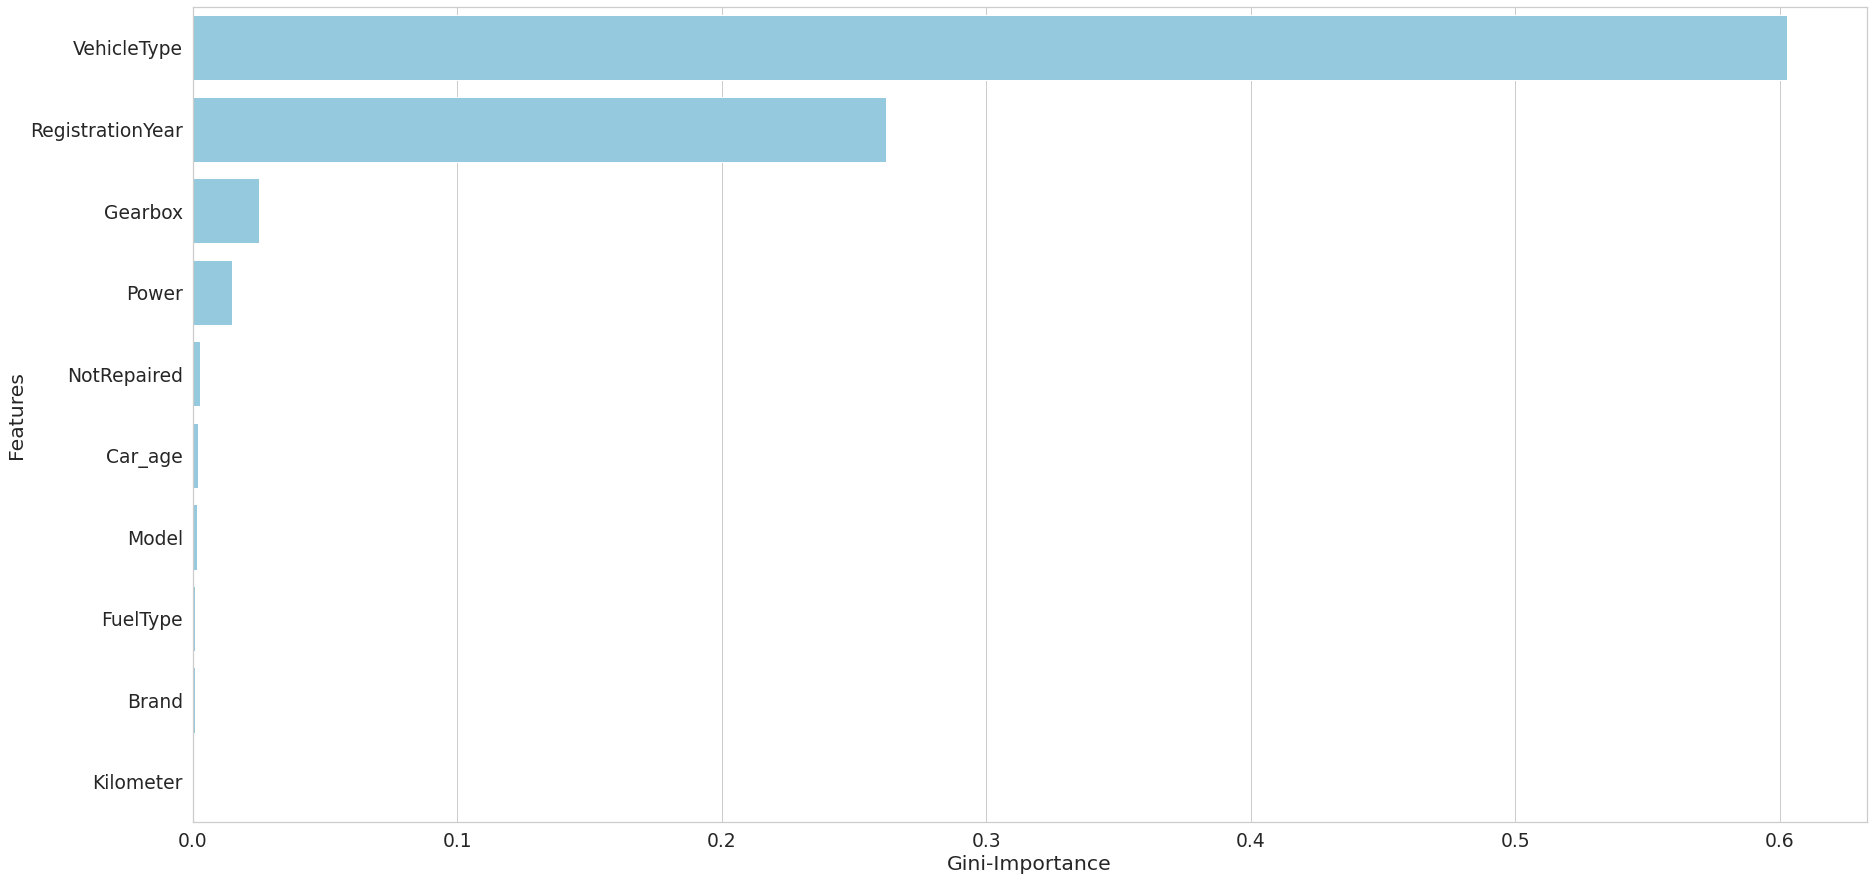

In [49]:
feats = {}
for feature, importance in zip(features.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue');

**Случайный лес**

In [50]:
%%time

model = RandomForestRegressor(random_state=12345, max_depth=10, n_estimators=21)
model.fit(ohe_features, target_train)

CPU times: user 46.4 s, sys: 153 ms, total: 46.5 s
Wall time: 46.9 s


RandomForestRegressor(max_depth=10, n_estimators=21, random_state=12345)

In [51]:
%%time

predict = model.predict(ohe_features_test)

CPU times: user 159 ms, sys: 56.6 ms, total: 216 ms
Wall time: 226 ms


In [52]:
print('RMSE для случайного леса:',mean_squared_error(target_test, predict) ** 0.5)

RMSE для случайного леса: 1914.2501382505843


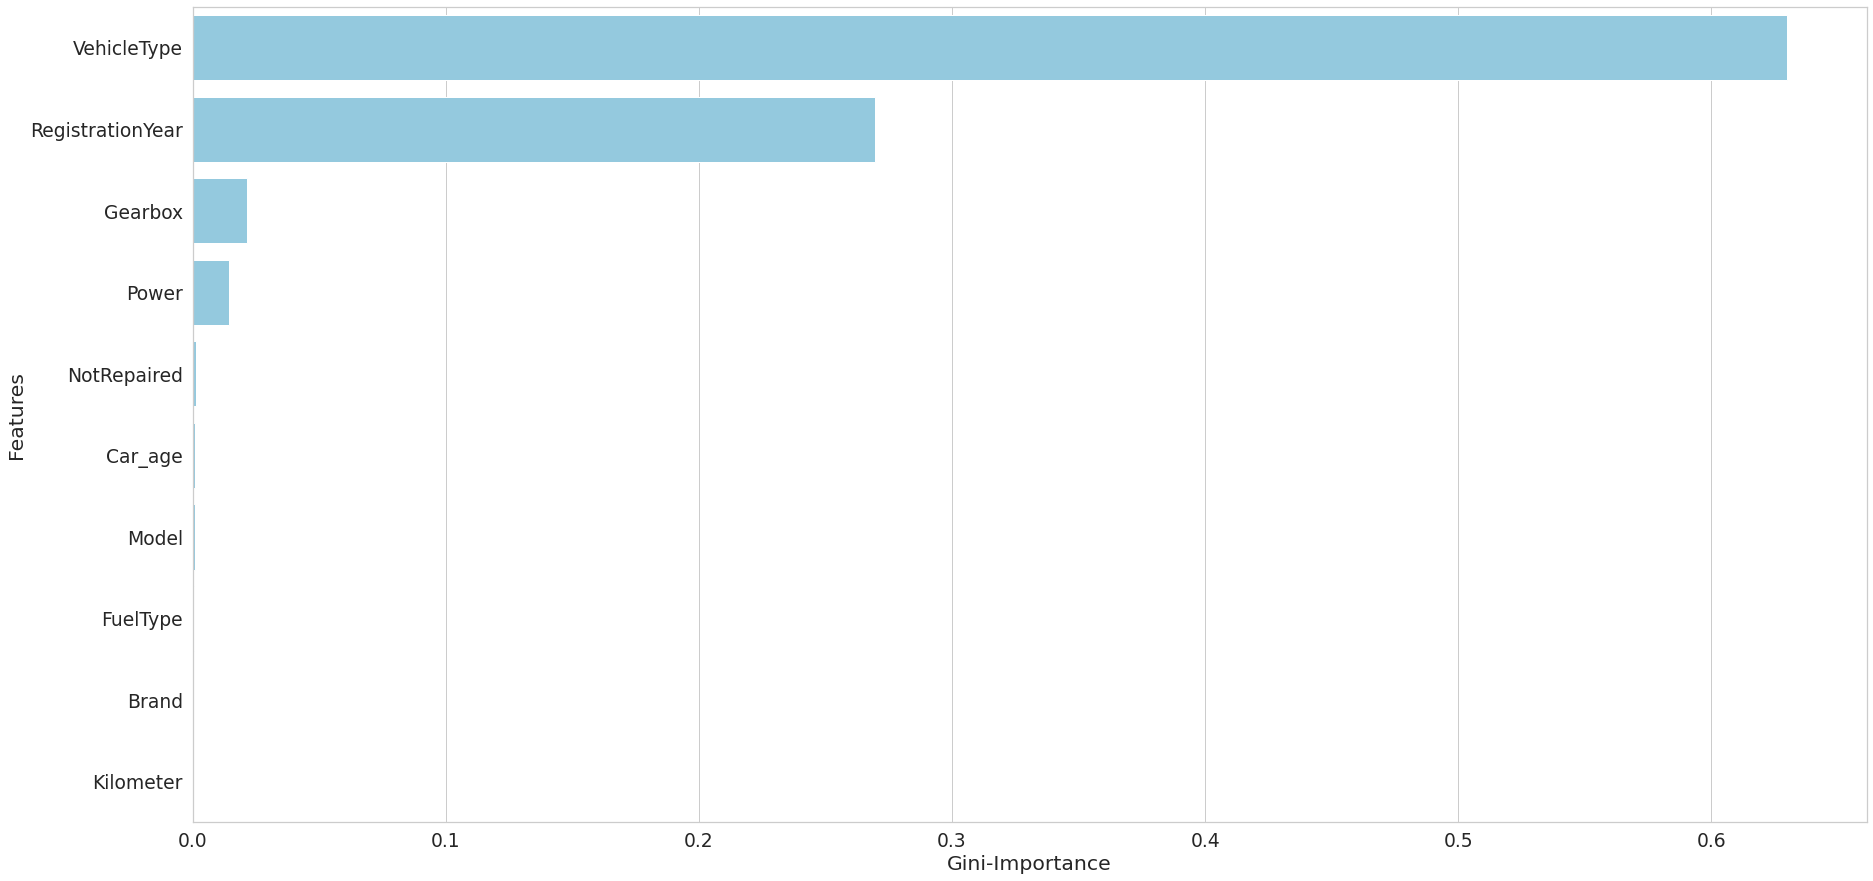

In [53]:
feats = {}
for feature, importance in zip(features.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue');

**CatBoost**

In [54]:
%%time

model = CatBoostRegressor(learning_rate=0.1, random_state=12345, verbose=False, cat_features=categorical_feats)
model.fit(features_train, target_train)

CPU times: user 2min 35s, sys: 463 ms, total: 2min 35s
Wall time: 2min 38s


In [55]:
%%time

predict = model.predict(features_test)

CPU times: user 491 ms, sys: 12.1 ms, total: 503 ms
Wall time: 501 ms


In [56]:
print('RMSE для CatBoost:',mean_squared_error(target_test, predict) ** 0.5)

RMSE для CatBoost: 1621.7166048874008


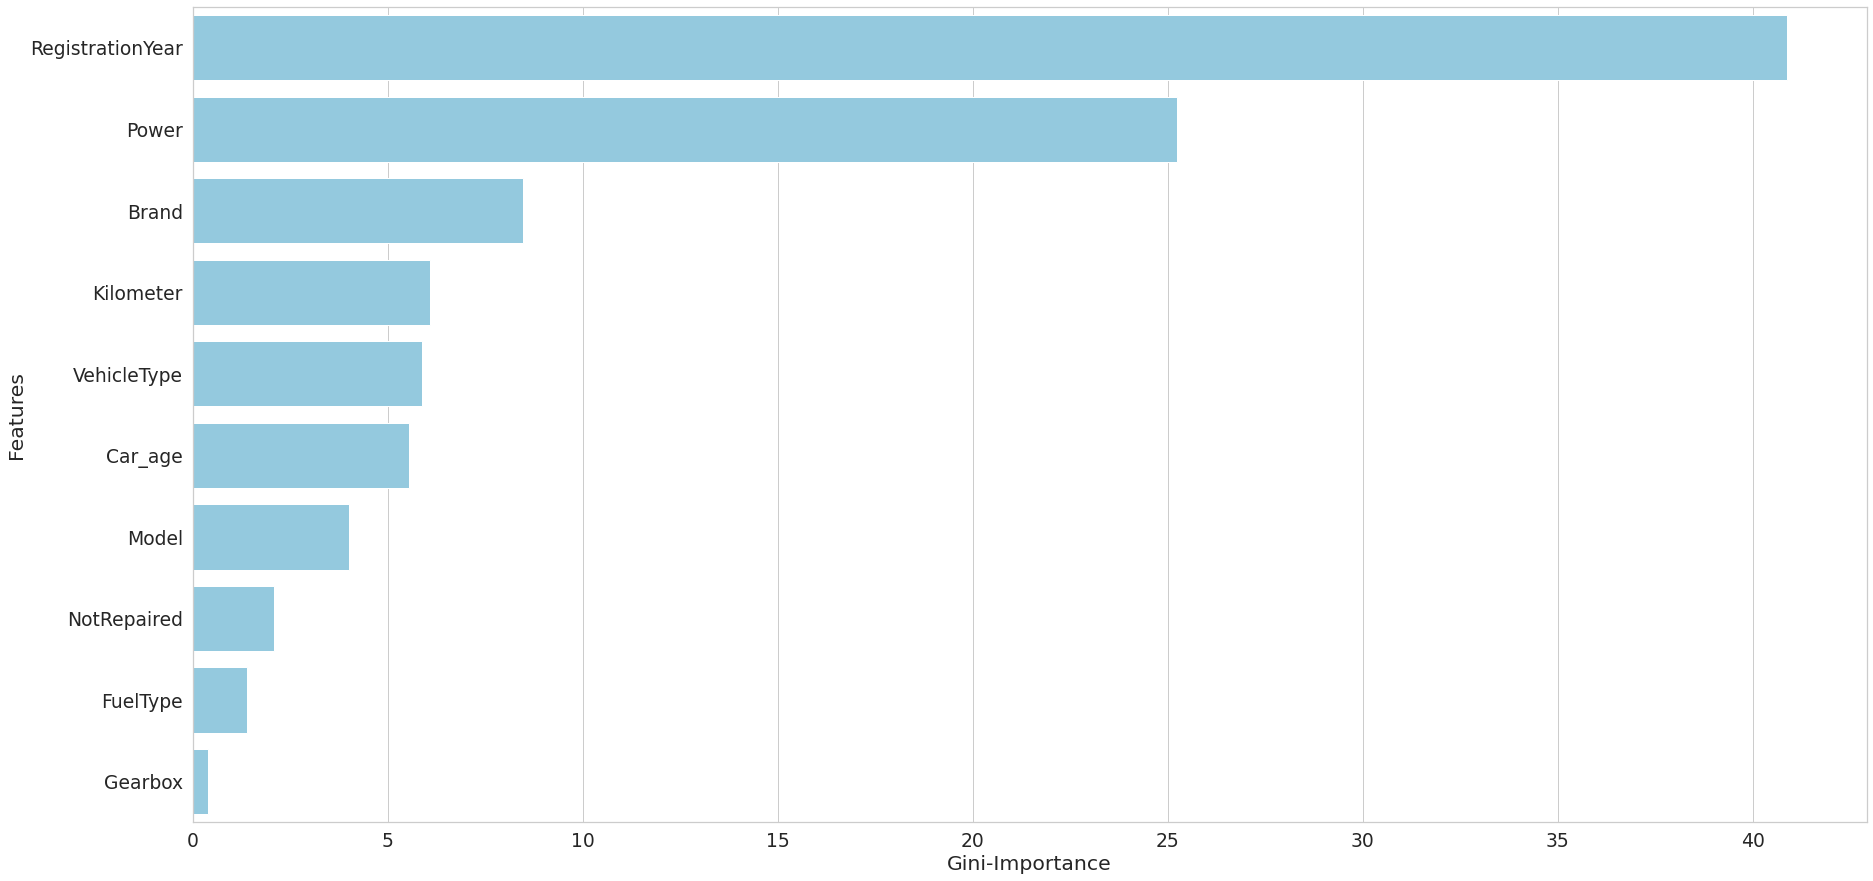

In [57]:
feats = {}
for feature, importance in zip(features.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue');

**LGBM**

In [58]:
%%time

model = LGBMRegressor(random_state=12345, objective='regression', n_estimators=151, num_leaves=200)
model.fit(ohe_features, target_train)

CPU times: user 1min 6s, sys: 521 ms, total: 1min 6s
Wall time: 1min 7s


LGBMRegressor(n_estimators=151, num_leaves=200, objective='regression',
              random_state=12345)

In [59]:
%%time

predict = model.predict(ohe_features_test)

CPU times: user 1.42 s, sys: 84.5 ms, total: 1.51 s
Wall time: 1.51 s


In [60]:
print('RMSE для LGBM:',mean_squared_error(target_test, predict) ** 0.5)

RMSE для LGBM: 1593.7654021445885


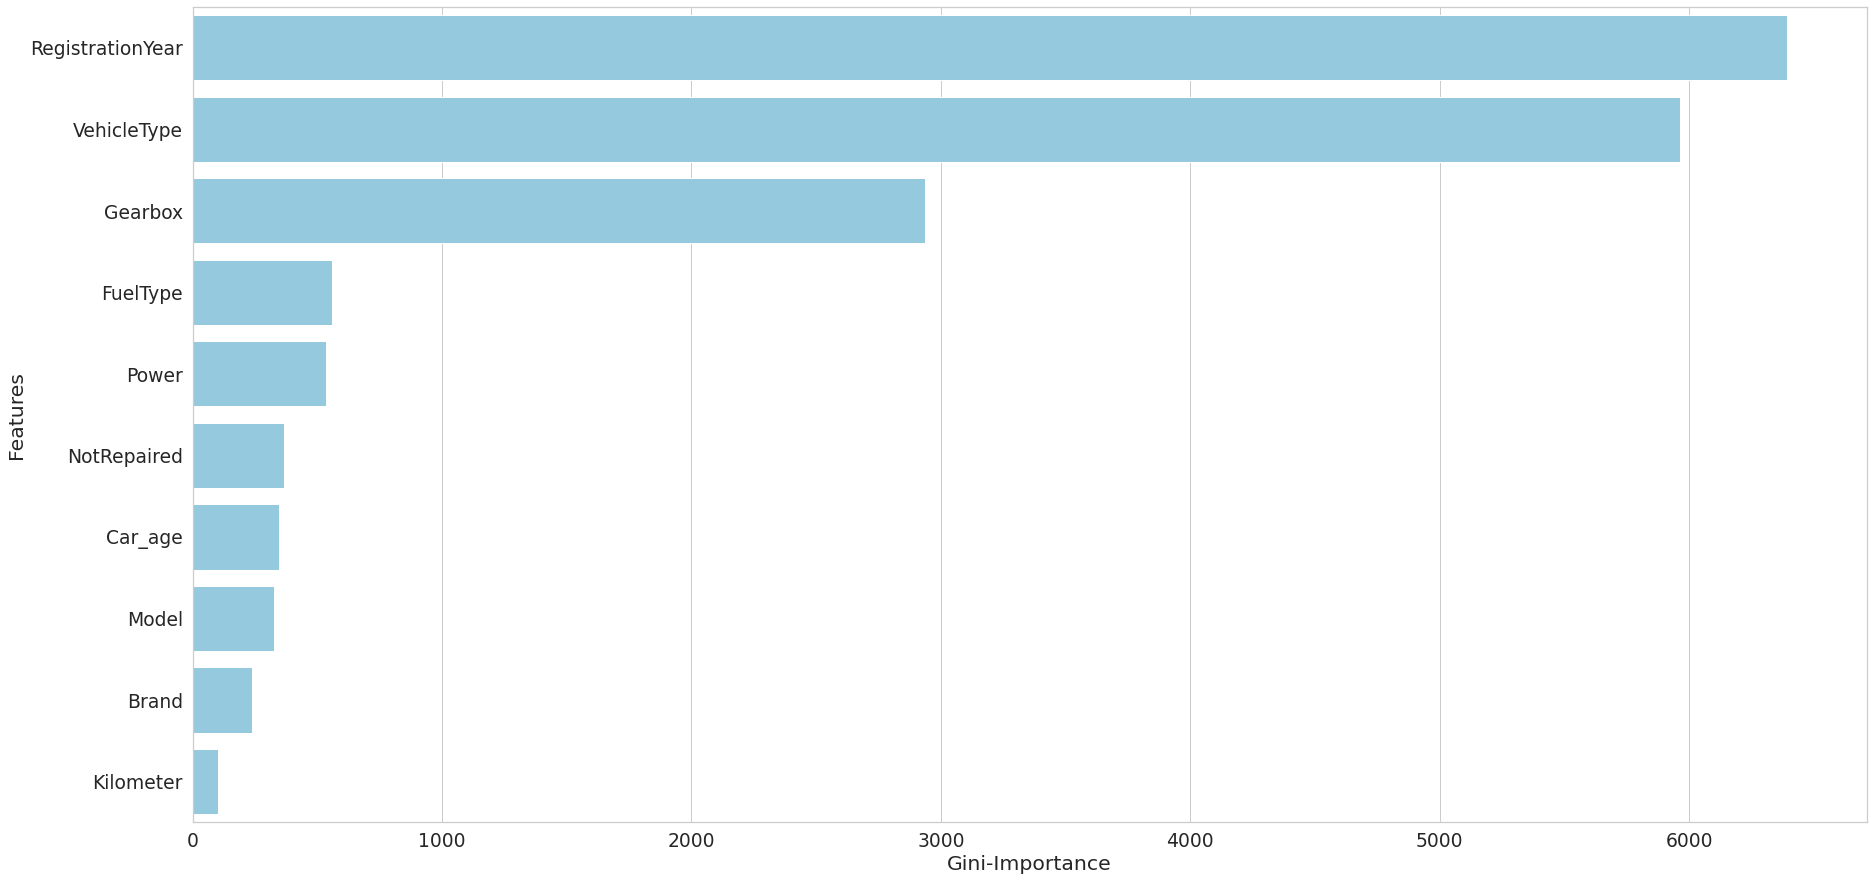

In [61]:
feats = {}
for feature, importance in zip(features.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue');

In [62]:
# создание таблицы
data = [['18.2 s', '228 ms', 2344.6],
        ['4.25 s', '122 ms', 1896.2],
        ['46.9 s', '226 ms', 1914.2],
        ['2min 38s', '501 ms', 1621.7],
        ['1min 7s', '1.51 s', 1593.7]]
models = ['Linear', 'Tree', 'Forest', 'Catboost', 'LGBM']

pd.DataFrame(data=data, index=models, columns=['fit_time', 'predict_time', 'RMSE'])

,fit_time,predict_time,RMSE
Linear,18.2 s,228 ms,2344.6
Tree,4.25 s,122 ms,1896.2
Forest,46.9 s,226 ms,1914.2
Catboost,2min 38s,501 ms,1621.7
LGBM,1min 7s,1.51 s,1593.7


Таким образом, быстрее всех обучается и предсказывает модель дерева решений, при этом значение метрики RMSE у данной модели 1896.2, что больше чем у модель LGBMRegressor. LGBM показала самое лучшее значение RMSE из всех моделей. Чуть хуже оказалось значение метрики у Catboost, однако данная модель обучается и предсказывает дольше остальных.